# 01 | Baseline Model  

**Objective:**
Train a simple logistic regression on the engineered data to establish a performance benchmark.

**Approach:**
- Use minimal feature engineering to simulate a realistic baseline.
- Evaluate model with ROC-AUC, PR-AUC, F1 score, and confusion matrix.
- Interpret results and feature importance.

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay


## Load Engineered Dataset  
We’ll pull from our `credit_risk_engineered` table in the SQLite DB.

In [ ]:
conn = sqlite3.connect("../data/loanvet.db")
df = pd.read_sql_query("SELECT * FROM credit_risk_baseline", conn)
conn.close()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,NumberOfTime30-59DaysPastDueNotWorse_log,NumberOfTimes90DaysLate_log,NumberOfTime60-89DaysPastDueNotWorse_log,TotalDelinquencies_log,HighUtilizationFlag,IncomePerCreditLine,AgeGroup_MidAge,AgeGroup_Senior,DependentsGroup_Small,DependentsGroup_Large
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1.098612,0.000000,0.0,1.098612,0,651.428571,1,0,1,0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,0.000000,0.000000,0.0,0.000000,1,520.000000,1,0,1,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,0.693147,0.693147,0.0,1.098612,0,1014.000000,1,0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.000000,0.000000,0.0,0.000000,0,550.000000,1,0,0,0
4,0,0.907239,49,1,0.024926,50000.0,7,0,1,0,...,0.693147,0.000000,0.0,0.693147,1,6250.000000,1,0,0,0


## Drop Redundant Columns

In [ ]:
drop_cols = [
    'RevolvingUtilizationOfUnsecuredLines',
    'MonthlyIncome',
    'DebtRatio',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTime30-59DaysPastDueNotWorse_log',
    'NumberOfTimes90DaysLate_log',
    'NumberOfTime60-89DaysPastDueNotWorse_log',
    'TotalDelinquencies'
]
df = df.drop(columns=drop_cols, errors="ignore")

## Data Preprocessing Notes
To reduce multicollinearity and avoid redundancy, we dropped raw features that were either highly skewed or already represented by transformed versions:

- Original delinquency variables (e.g., `NumberOfTimes90DaysLate`) were replaced by their log-transformed versions or aggregated into `TotalDelinquencies_log`.
- Skewed continuous variables like `RevolvingUtilizationOfUnsecuredLines` and `MonthlyIncome` were dropped in favor of their log-transformed counterparts.
- The original `TotalDelinquencies` was also removed since the log-transformed version was used for modeling.

This step ensures the model focuses on cleaner, more interpretable signals while minimizing the risk of redundant information.

## Train/Test Split
Stratify on the target to preserve imbalance.

In [ ]:
X = df.drop(columns=["SeriousDlqin2yrs"])
y = df["SeriousDlqin2yrs"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Baseline Model
Logistic regression is chosen as the baseline due to its simplicity, interpretability, and speed. To address class imbalance in the data, we use `class_weight='balanced'`.

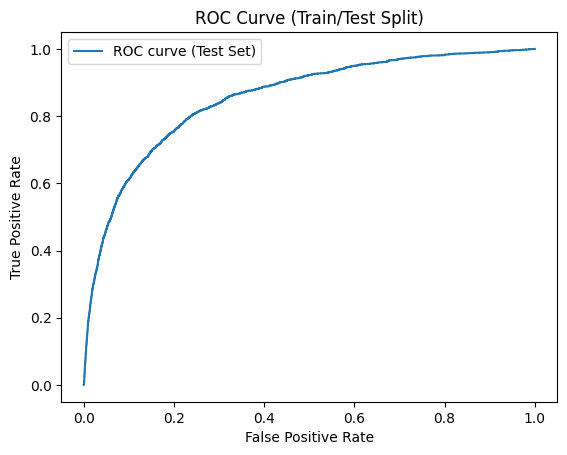

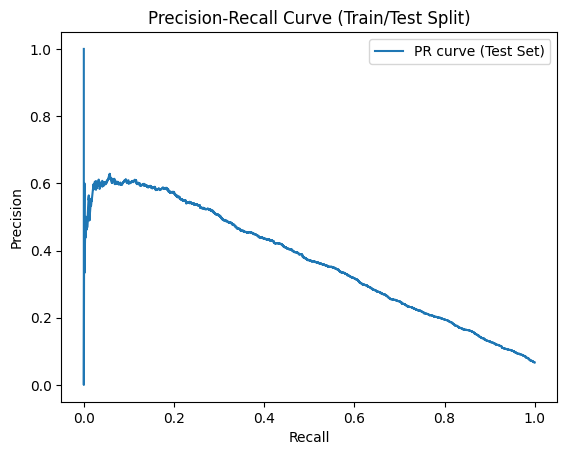

In [ ]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight="balanced", max_iter=1000)
)

pipeline.fit(X_train, y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

y_pred = (y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, y_pred)

print(f"Train/Test Split ROC-AUC: {roc_auc:.4f}")
print(f"Train/Test Split PR-AUC: {pr_auc:.4f}")
print(f"Train/Test Split F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Train/Test Split Confusion Matrix:")
print(cm)

## Preliminary Train/Test Split Evaluation

Before performing more robust cross-validation, we conduct an initial evaluation using a single train/test split.

- This quick check ensures our pipeline works end-to-end without errors.
- However, metrics from a single split can be unstable and heavily dependent on how the data is divided.
- Therefore, these results serve as a sanity check rather than a final performance measure.

For reliable and generalizable model evaluation, we proceed with stratified 5-fold cross-validation, which averages performance across multiple splits and reduces variance due to random sampling.

## Performance Metrics
Evaluate model using key classification metrics that reflect imbalanced data performance:

ROC-AUC: Measures overall ranking ability between classes.

PR-AUC: Focuses on precision and recall trade-off, important for imbalanced datasets.

F1 Score: Harmonic mean of precision and recall at 0.5 threshold.

Confusion Matrix: Summarizes true positives, false positives, true negatives, and false negatives across folds.

Mean ROC-AUC: 0.8556 ± 0.0032
Mean PR-AUC: 0.3706 ± 0.0113
Mean F1: 0.3345 ± 0.0028
Summed Confusion Matrix across folds:
[[112241  27141]
 [  2549   7460]]


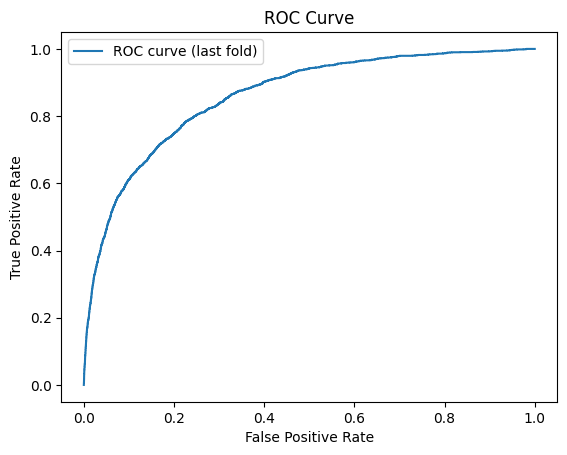

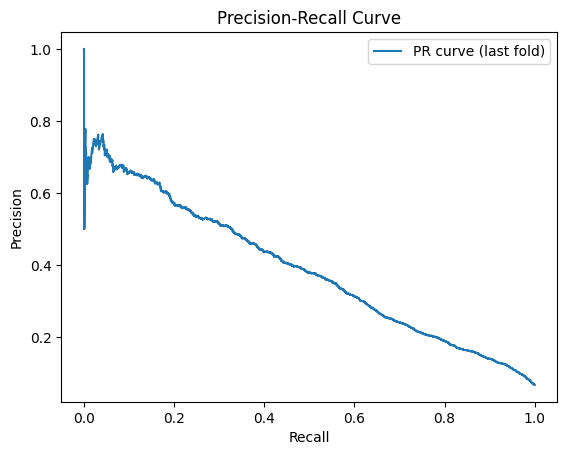

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []
pr_auc_scores = []
f1_scores = []
cm_sum = np.array([[0, 0], [0, 0]])

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
    )
    pipeline.fit(X_train, y_train)
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
    f1_scores.append(f1)
    cm_sum += cm

print(f"Mean ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Mean PR-AUC: {np.mean(pr_auc_scores):.4f} ± {np.std(pr_auc_scores):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print("Summed Confusion Matrix across folds:")
print(cm_sum)

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC curve (last fold)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

plt.plot(recall, precision, label='PR curve (last fold)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

## Performance Interpretation

- **ROC-AUC (~0.856)**: The model does reasonably well at ranking positive vs negative examples.
- **PR-AUC (~0.371)**: Indicates moderate performance on the minority class; much harder than ROC-AUC due to imbalance.
- **F1 Score (~0.33)**: Balanced harmonic mean of precision and recall; suggests decent balance between false positives and false negatives.
- **Confusion Matrix**: Aggregated across folds, gives a more stable view of how many defaults the model missed or falsely predicted.

Overall, the baseline shows promising separation but has limitations in precision/recall on the minority class.

## Feature Importance  

Logistic regression provides direct interpretability through feature coefficients. This helps identify which features are most influential in predicting credit risk.

In [ ]:
logreg_model = pipeline.steps[-1][1]

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": logreg_model.coef_[0]
})

coef_df = coef_df.assign(abs_coef=lambda d: d.coef.abs()).sort_values("abs_coef", ascending=False)

print(coef_df.head(10))


                                     feature      coef  abs_coef
9                     TotalDelinquencies_log  0.788048  0.788048
6   RevolvingUtilizationOfUnsecuredLines_log  0.689448  0.689448
8                              DebtRatio_log -0.314060  0.314060
0                                        age -0.291139  0.291139
4                 MonthlyIncome_missing_flag  0.265094  0.265094
1            NumberOfOpenCreditLinesAndLoans  0.190339  0.190339
2               NumberRealEstateLoansOrLines  0.136626  0.136626
7                          MonthlyIncome_log -0.135310  0.135310
10                       HighUtilizationFlag  0.040241  0.040241
13                           AgeGroup_Senior -0.035346  0.035346


## Feature Importance Interpretation

- **TotalDelinquencies_log** and **RevolvingUtilizationOfUnsecuredLines_log** have the strongest positive coefficients, meaning higher values increase the likelihood of default.
- **DebtRatio_log** and **age** have negative coefficients, suggesting that older age and lower debt ratios are associated with lower risk.
- **MonthlyIncome_missing_flag** is positively correlated with default, which implies missing income data might be a proxy for higher risk.
- **HighUtilizationFlag** also contributes positively, albeit to a lesser extent — reinforcing that credit max-out behavior is risky.
- Categorical binning like **AgeGroup_Senior** slightly lowers predicted risk, which aligns with domain intuition.

These insights help validate the model’s learning against financial reasoning, and set expectations for which features we want future models to explain or improve upon.


## Conclusions

- The logistic regression baseline sets a strong foundation, with **ROC-AUC of 0.856** and reasonable **PR-AUC** and **F1**.
- Key drivers include late payment history and revolving credit utilization.
- There is still room to improve recall and precision, which future models (e.g., tree-based ensembles) may better capture.
- This baseline will be used for comparison against more advanced models trained on the fully engineered dataset.